# Рынок заведений общественного питания Москвы

**Задачи проекта**:
1. Оценить текущую ситуацию на рынке общественного питания г. Москва для открытия кафе
2. Дать рекомендации:
    - о формате заведения
    - потенциальному месторасположению
    - количестве посадочных мест

**Содержание**

* [1. Подготовка датасета к анализу](#1)
* [2. Анализ данных](#2)
* [3. Выводы и рекомендации](#3)

<a id='1'></a>
## Подготовка датасета к анализу

Импортируем все необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib as plt
import plotly.express as px
from io import BytesIO
import requests

Сохраним датасет в переменной `data`, изучим основную информацию.

In [2]:
data = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/2. Исследование рынка заведений общественного питания Москвы/data.csv')
display (data.head ())
data.info ()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Датасет состоит из более чем 15 тысяч записей и содержит 6 колонок:
* `id` - идентификатор объекта
* `object_name` - название объекта общественного питания
* `chain` - сетевой ресторан
* `object_type` - тип объекта общественного питания
* `address` - адрес
* `number` - количество посадочных мест

Типы данных соответствуют информации в колонках.

Переименуем колонку `number` в `seat_number`, чтобы было удобнее работать с данными.

In [3]:
data = data.rename (columns = {'number': 'seat_number'})

Проверим наличие пропусков в данных.

In [4]:
data.isna().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
seat_number    0
dtype: int64

Пропусков в данных не обнаружено. Проверим дубликаты в записях.

In [5]:
data.duplicated().sum()

0

Явных дубликатов в датасете нет. Проверим также дубликаты по колонке `id`

In [6]:
data ['id'].duplicated().sum()

0

Дубликаты в таблице отсутствуют. Стоит отдельно проверить дубликаты без колонки `id`.

In [7]:
data [['object_name', 'chain', 'object_type', 'address', 'seat_number']].duplicated().sum()

82

Имеется 82 записи с дубликатами, их можно удалить, т.к. объем этих данных не превышает 1% от всего датасета.

In [8]:
data = data.drop_duplicates (subset = data.columns.difference(['id'])).reset_index (drop = True)

Посмотрим на количественные значения колонки `seat_number`.

In [9]:
data ['seat_number'].describe()

count    15284.000000
mean        59.784350
std         74.838657
min          0.000000
25%         14.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: seat_number, dtype: float64

В колонке имеются данные о заведениях без посадочных мест. Посмотрим на их количество.

In [10]:
len (data [data ['seat_number'] == 0])

1589

Более 10% заведений без посадочных мест. Причиной может быть как ошибки в данных, так и отсутствие мест в действительности (например, для небольших заведений с принципом работы "на вынос" - небольшие точки, где отсутствуют посадочные места как таковые). Удалять такой объем данных не стоит, т.к. их слишком много, это может повлиять на результаты исследования.

Предобработка общих данных закончена, можно переходить к анализу.

<a id='2'></a>
## Анализ данных
Начнём анализ с соотношения видов объектов общественного питания по количеству.

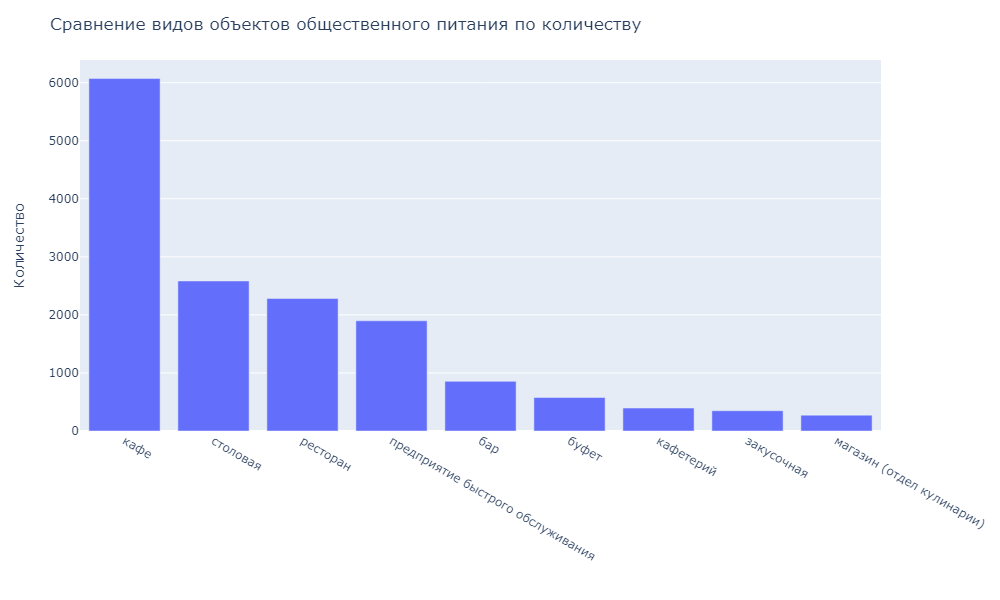

In [11]:
def fig_set (fig, title, xt, yt):
    fig.update_layout (title = title,
                       xaxis_title = xt,
                       yaxis_title = yt)
    fig.show ('png')

fig_1 = px.bar (data.groupby ('object_type')['object_type'].count().sort_values (ascending = False),
                y = 'object_type',
                width = 1000,
                height = 600)
fig_set (fig_1, 'Сравнение видов объектов общественного питания по количеству', '', 'Количество')

Больше всего в датасете данных о кафе (более 6000). Столовые, рестораны и предприятия быстрого питания находятся в диапазоне от 1 до 3 тысяч объектов, остальные объекты занимают незначительную долю (менее 1000 объектов).

Рассмотрим соотношение сетевых и несетевых заведений по количеству.

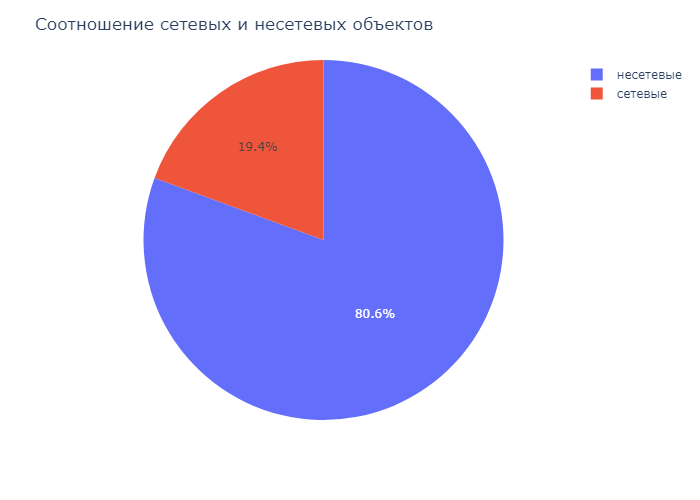

In [12]:
fig_2 = px.pie (data.groupby ('chain')['id'].count().reset_index(),
                values = 'id',
                names = ['сетевые', 'несетевые'])
fig_set (fig_2, 'Соотношение сетевых и несетевых объектов', '', '')

In [13]:
print ('Доля сетевых заведение в датасете: ', round (len (data [data ['chain'] == 'да']) / len (data) * 100, 1), '%')

Доля сетевых заведение в датасете:  19.4 %


Большинство заведений не относится к сетевым. Сетевые заведения занимают менее 20% от общего количества объектов.

Рассмотрим, для какого вида объекта общественного питания характерно сетевое распространение.

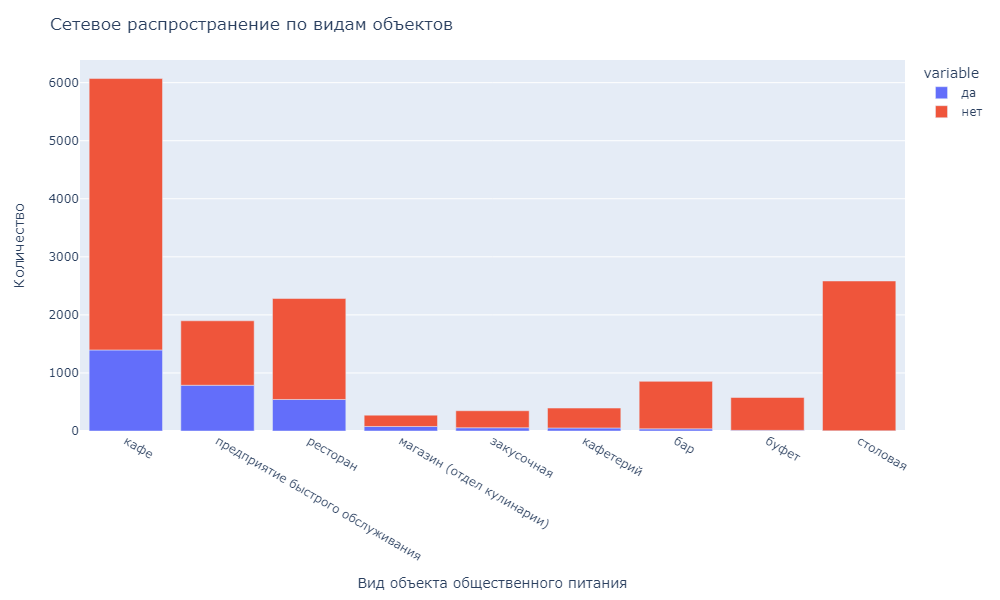

In [14]:
data_pivot = data.pivot_table (index = 'object_type', columns = 'chain', values = 'id', aggfunc = 'count')
fig_3 = px.bar (data_pivot.sort_values (by = 'да', ascending = False),
                y = ['да', 'нет'],
                width = 1000,
                height = 600)
fig_set (fig_3, 'Сетевое распространение по видам объектов', 'Вид объекта общественного питания', 'Количество')

Из графика видно, что кафе, предприятия быстрого питания и рестораны имеют значительные доли сетевых заведений. Однако, график построен по количеству заведений, а не по долям. Сравним доли сетевых заведений по видам объектов.

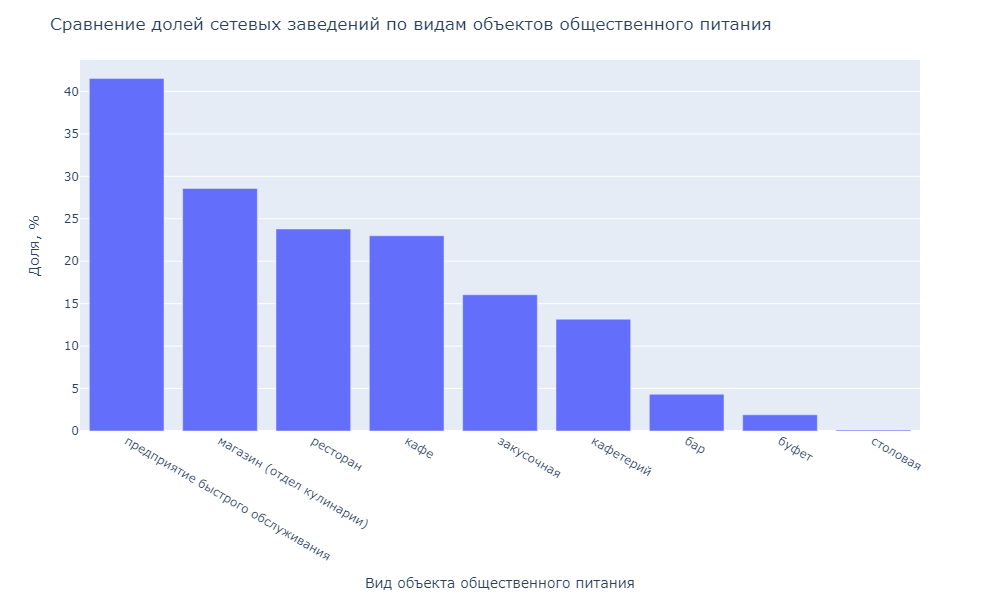

In [15]:
data_pivot ['ratio'] = (data_pivot ['да'] / (data_pivot ['да'] + data_pivot ['нет'])) * 100
fig_4 = px.bar (data_pivot.sort_values (by = 'ratio', ascending = False),
                y = 'ratio',
                width = 1000,
                height = 600)
fig_set (fig_4, 'Сравнение долей сетевых заведений по видам объектов общественного питания', 'Вид объекта общественного питания', 'Доля, %')

Из построенного графика можно сделать вывод о том, что наиболее характерно сетевое распределение для предприятий быстрого питания (более 40% заведений от общего количества этого вида). Магазины с отделами кулинарии, рестораны и кафе в 20-30% случаев являются сетевыми. Остальные виды заведений имеют долю сетевых 15% и менее.

Рассмотрим сетевые заведения более подробно. Сгруппируем данные по названию заведений и посмотрим на их количество.

In [16]:
data_chain = data.query ('chain == "да"')
data_chain.groupby ('object_name')['id'].count().reset_index().sort_values(by = 'id')

,object_name,id
0,Beverly Hills Diner,1
436,Мюнгер,1
435,Му-му,1
433,Молли гвинз,1
431,Мираторг,1
...,...,...
195,Домино'с Пицца,86
418,Макдоналдс,121
127,Бургер Кинг,122
702,Шоколадница,141


В таблице 724 уникальных названий заведений, однако, в таблице имеются дубликаты из-за разного написания одних и тех же заведений. Проведём первичную обработку данных - приведём названия всех заведений к нижнему регистру.

In [17]:
pd.options.mode.chained_assignment = None
data_chain ['object_name'] = data_chain ['object_name'].str.lower()
data_chain.groupby ('object_name')['id'].count().reset_index().sort_values (by = 'id')

,object_name,id
0,beverly hills diner,1
341,мимино хинкальная,1
338,милано пицца,1
336,метро к&к,1
334,меленка,1
...,...,...
521,теремок,94
109,бургер кинг,137
330,макдоналдс,150
25,kfc,155


Первичная обработка позволила сократить 147 записей, являющиеся дубликатами из-за разных регистров. Проведём вторичную обработку - используем названия 50-и объектов, имеющих наибольшее количество заведений, для выявления дубликатов с этими же именами в названиях.

In [18]:
def update_name (name):
    for i in data_chain.groupby ('object_name')['id'].count().reset_index().sort_values (by = 'id').tail (50)['object_name']:
        if i in name:
            return i
    return name

data_chain ['object_name'] = data_chain ['object_name'].apply (update_name)
data_chain.groupby ('object_name')['id'].count().reset_index().sort_values (by = 'id')

,object_name,id
0,beverly hills diner,1
195,коста кофе,1
198,кофе тун,1
202,кофейня «costa coffee»,1
203,кофейня «дабл би»,1
...,...,...
351,теремок,111
91,бургер кинг,159
384,шоколадница,167
225,макдоналдс,172


Вторичная обработка позволила сократить ещё 184 записи. Перейдём к итоговой обработке - визуальной. Отсортируем все уникальные оставшиеся уникальные значения `object_name` и приведём названия к единому виду.

In [19]:
data_chain ['object_name'].unique()

array(['пиццетория', 'брусника', 'алло пицца', 'суши wok', 'тануки',
       "домино'с пицца", 'готика', 'му-му', 'хлеб насущный', 'tajj mahal',
       'данкин донатс', 'вареничная №1', 'шоколадница', 'теремок',
       'хинкальная', 'шантимель', 'кружка', 'суши вок', 'примавера',
       'виктория', 'пиццерия «академия»', 'чебуречная ссср', 'макдоналдс',
       'grand cru', 'чайхона №1', 'панчо пицца', 'kfc', 'сабвей',
       'якитория', 'советские времена', 'андерсон', 'subway', 'суши сет',
       'шоколад', 'тирольские пироги', 'гамбринус', 'пицца фабрика',
       'сити пицца', 'кофе хаус', 'кулинарная лавка братьев караваевых',
       'прайм', 'пицца экспресс', 'николай', 'магнолия', 'кофе с собой',
       'джаганнат', 'волконский', 'moskalyan', 'гино-но-таки',
       'тратория semplice', 'ньокки', 'хижина', 'додо пицца',
       'крошка картошка', 'бургер кинг', 'папа джонс',
       'бар- буфет «николай»', 'ресторан «тануки»', 'две палочки',
       'джон джоли', 'ваби-саби', 'кофемани

In [20]:
new_words = {'burger club': 'бургер клаб',
             'coffeeshop': ['кофешоп coffeeshop company', 'coffeeshop company'],
             'costa coffee': 'брава коста кофе',
             'dunkin donuts': ['кафе «данкин донатс»', 'данкин донатс'],
             'kfc': 'кафе «kfc»',
             'krispy kreme': ['krispy creme', 'krispy krem'],
             'starbucks': 'старбакс',
             'subway': 'сабвей',
             'tutti frutti': ['кафе мороженного «tutti frutti»', 'tutti frutti frozen yogurt'],
             'суши wok': 'суши вок',
             'кофетун': ['кафе кофе тун', 'кофе тун кофетун', '"суши тун, хруст pizza, кофе тун"', 'суши тун'],
             'мята lounge': 'мята',
             'пипони': ['пиппони', 'пицца пипони'],
             'кофе хауз': ['кафе кофе-хаус', 'кофе-хаус'],
             'то да сё': 'кафе «то да сё»',
             'папа джонс': 'пиццерия «папа джонс»',
             'магбургер': ['магбургер азс №16', 'магбургер азс №17', 'предприятие быстрого обслуживания «магбургер»'],
             'маки-маки': ['ресторан маки-маки', 'суши бар «маки-маки»', 'ресторан японской кухни «маки-маки»', 'суши «маки-маки»'],
             'чебуречная ссср': ['советские времена чебуречная ссср', 'советские времена'],
             'иль-патио': 'иль патио',
             'torro grill': ['торро гриль', 'torro grill торро гриль', 'ресторан торро гриль'],
             'даблби': ['кофейня «дабл би»', 'дабл би блэк', 'дабл би'],
             'азбука вкуса': ['бар азбука вкуса', 'ав-дейли азбука вкуса'],
             'братья караваевы': ['кулинарная лавка братьев караваевых', 'братья караваевых'],
             'ёрш': 'ресторан «ёрш»'}

def update_name_last (word):
    for i, j in new_words.items():
        if word in j: return i
    return word
data_chain ['object_name'] = data_chain ['object_name'].apply (update_name_last)
data_chain_group = data_chain.groupby ('object_name')[['object_name', 'seat_number']].agg ({'object_name': 'count',
                                                                                            'seat_number': 'median'})
data_chain_group

,object_name,seat_number
object_name,,
beverly hills diner,1,88.0
bierloga,1,75.0
black & white,1,40.0
bocconcino,3,68.0
boobo,1,46.0
...,...,...
якитория,50,100.0
ямми микс,1,2.0
ян примус,1,300.0


После итоговой обработки осталось 352 сети, которые можно использовать при анализе. Для сравнения необходимо установить границы по количеству заведений и посадочных мест. Посмотрим распределение значений в обеих колонках методом `describe`.

In [21]:
data_chain_group.describe()

,object_name,seat_number
count,352.000000,352.000000
mean,8.420455,63.455966
std,23.094490,55.345356
min,1.000000,0.000000
25%,1.000000,20.000000
50%,2.000000,50.000000
75%,4.000000,90.000000
max,188.000000,306.000000


"Малым" количеством можно считать значения до 25% от всего распрелеления, "Много" - от 75%. Однако, по количеству заведений между границей 75% и максимальным количеством очень большая разница. Проверим распределение значений по диаграмме размаха.

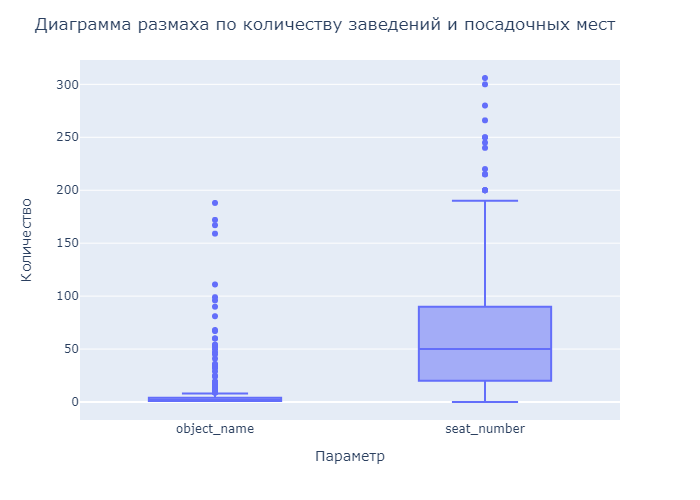

In [22]:
fig_5 = px.box (data_chain_group, y = ['object_name', 'seat_number'])
fig_set (fig_5, 'Диаграмма размаха по количеству заведений и посадочных мест', 'Параметр', 'Количество')

Основная масса значений количества заведений стремится к 1. Есть много выбивающихся значений, однако, их количество не критично. Примем крайнюю границу "нормального" количества заведений = 8 (граница правого уса). Построим диаграмму рассеяния, отражающую количество заведений и посадочных мест по выделенным группам.

In [23]:
def group_name (x):
    if x.object_name <= 1 and x.seat_number < 20:
        return 'Мало заведений \ Мало мест'
    elif x.object_name <= 1 and x.seat_number > 90:
        return 'Мало заведений \ Много мест'
    elif x.object_name > 8 and x.seat_number < 20:
        return 'Много заведений \ Мало мест'
    elif x.object_name > 8 and x.seat_number > 90:
        return 'Много заведений \ Много мест'
    else:
        return 'Среднее распределение'
data_chain_group ['group'] = data_chain_group.apply (group_name, axis = 1)
data_chain_group ['count'] = 1
data_chain_group.groupby ('group').agg ({'count': 'count',
                                         'object_name': 'median',
                                         'seat_number': 'median'}).sort_values (by = 'count',
                                                                                ascending = False).rename (columns = {'group': 'Группа',
                                                                                                                      'count': 'Количество сетей',
                                                                                                                      'object_name': 'Медианное кол-во заведений',
                                                                                                                      'seat_number': 'Медианное кол-во мест'})

,Количество сетей,Медианное кол-во заведений,Медианное кол-во мест
group,,,
Среднее распределение,254,2.0,49.75
Мало заведений \ Много мест,40,1.0,125.00
Мало заведений \ Мало мест,34,1.0,8.50
Много заведений \ Мало мест,14,21.0,6.00
Много заведений \ Много мест,10,22.5,105.00


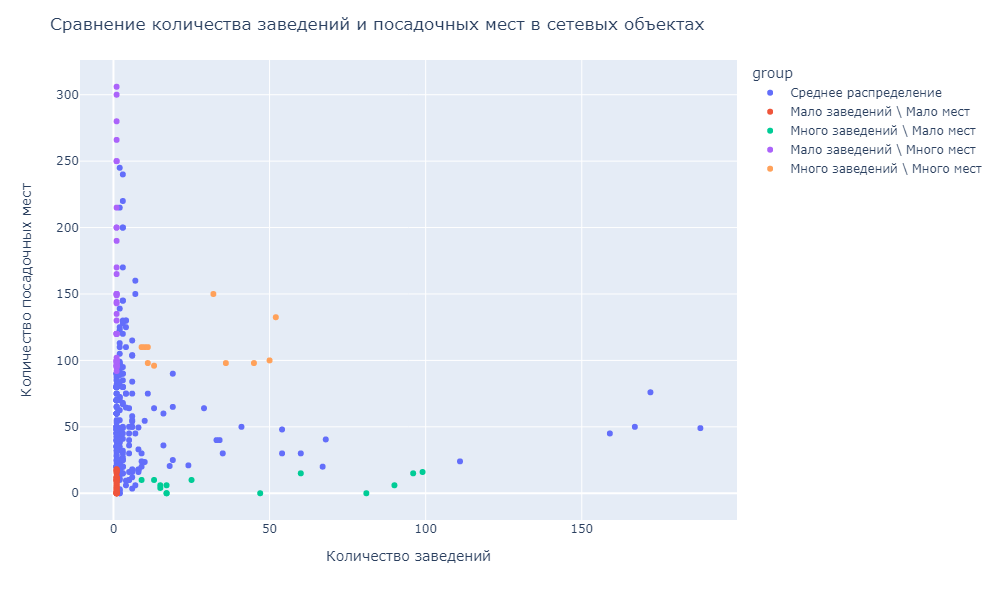

In [24]:
fig_6 = px.scatter (data_chain_group, x = 'object_name', y = 'seat_number', color = 'group', width = 1000, height = 600)
fig_set (fig_6, 'Сравнение количества заведений и посадочных мест в сетевых объектах', 'Количество заведений', 'Количество посадочных мест')

Как и ожидалось, среднее распределение занимает наиболее крупную группу.

Среди остальных групп следует отметить наиболее высокую вероятность встретить сетевой объект с небольшим количеством заведений и большим количетвом мест - это наиболее распространённое явление.

Также немало сетевых объектов с небольшим количестом заведений и небольшим количеством мест. Возможно, на это влияет доля заведений с принципом работы "на вынос" - небольшие точки, где отсутствуют посадочные места как таковые.

Остальные две группы занимают примерно одинаковое распределение - это сетевые объекты с большим количеством заведений, вне зависимости от количества мест. Эти две группы наименее распространены среди сетевых заведений в Москве.

Рассмотрим данные о количестве посадочных мест для каждого вида объекта общественного питания.

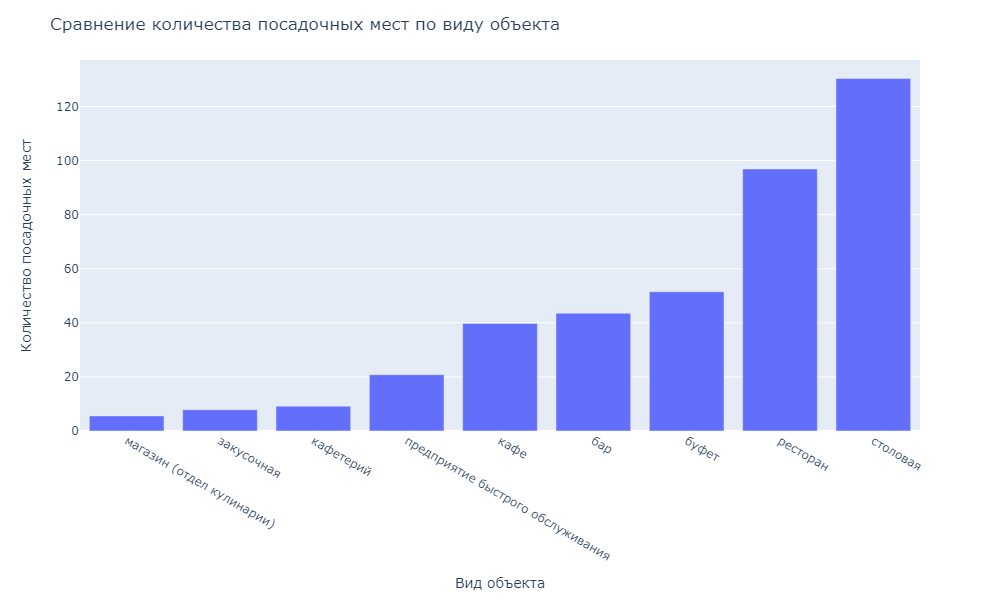

In [25]:
fig_7 = px.bar (data.groupby ('object_type')['seat_number'].mean().sort_values(), y = 'seat_number', width = 1000, height = 600)
fig_set (fig_7, 'Сравнение количества посадочных мест по виду объекта', 'Вид объекта', 'Количество посадочных мест')

В среднем больше всего посадочных мест в столовых и ресторанах (80-130 мест), во вторую группу по численности посадочных мест можно отнести буфеты, бары и кафе (40-50 мест). Остальные виды имеют минимальное количество мест (до 20 шт).

Создадим новый столбец в датасете, в котором будет указана улица расположения заведения.

In [26]:
variants = ['улица', 'ул.', 'проспект', 'шоссе', 'переулок', 'бульвар', 'проезд', 'набережная', 'аллея', 'площадь', 'тупик', 'квартал', 'линия']
def street_choice (name):
    for i in range (len (name.split (','))):
        for j in variants:
            if j in name.split (',')[i]:
                return name.split (',')[i]
    return 'нет'        
data ['address'] = data ['address'].str.lower()
data ['street'] = data ['address'].apply (street_choice)
data [data ['street'] == 'нет']

,id,object_name,chain,object_type,address,seat_number,street
1405,20199,ЭТО,нет,кафе,"город москва, город зеленоград, корпус 401",35,нет
1406,68113,Френдс,нет,кафе,"город москва, город зеленоград, корпус 435",34,нет
1407,20105,Кафе «Граф Монте-Кристо»,нет,кафе,"город москва, город зеленоград, корпус 436",40,нет
1408,22982,Альфорно,нет,кафе,"город москва, город зеленоград, корпус 438",49,нет
1409,151267,Альфорно,нет,кафе,"город москва, город зеленоград, корпус 438",45,нет
...,...,...,...,...,...,...,...
14917,216942,Шашлычный дворик,нет,кафе,"город москва, поселение десеновское, деревня в...",15,нет
14918,216926,Кафе «Сахли»,нет,закусочная,"город москва, поселение десеновское, деревня в...",10,нет
14935,208239,ГАЗПРОМНЕФТЬ,нет,кафе,"поселение ""мосрентген"", деревня дудкино, владе...",20,нет
15103,220587,Пицца Паоло,да,кафетерий,"город москва, город зеленоград, корпус 1627",0,нет


В датасете осталось 381 строк без указанной улицы - это примерно 2,5% от общего объема данных. Не критичный объем для удаления.

In [27]:
data = data [data ['street'] != 'нет'].reset_index()
data

,index,id,object_name,chain,object_type,address,seat_number,street
0,0,151635,СМЕТАНА,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова
1,1,77874,Родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина
2,2,24309,Кафе «Академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица
3,3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица
4,4,119365,Кафе «Вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица
...,...,...,...,...,...,...,...,...
14898,15279,208537,Шоколадница,да,кафе,"город москва, 3-й крутицкий переулок, дом 18",50,3-й крутицкий переулок
14899,15280,209264,Шоколадница,да,кафе,"город москва, улица земляной вал, дом 33",10,улица земляной вал
14900,15281,209186,Шоколадница,да,кафе,"город москва, улица земляной вал, дом 33",20,улица земляной вал
14901,15282,221900,Шоколадница,да,кафе,"город москва, поселение московский, киевское ш...",36,киевское шоссе


Найдём топ-10 улиц по количеству объектов общественного питания.

In [28]:
data.groupby ('street')['object_name'].count().sort_values().tail(10)

street
 кировоградская улица      108
 каширское шоссе           111
 кутузовский проспект      114
 проспект вернадского      128
 ленинский проспект        147
 варшавское шоссе          164
 пресненская набережная    167
 ленинградский проспект    170
 профсоюзная улица         181
 проспект мира             204
Name: object_name, dtype: int64

В списке отсортированных улиц есть некорректные значения "город Зеленоград" и "поселение Сосенское". Отфильтруем вхождения для получения корректного списка улиц.

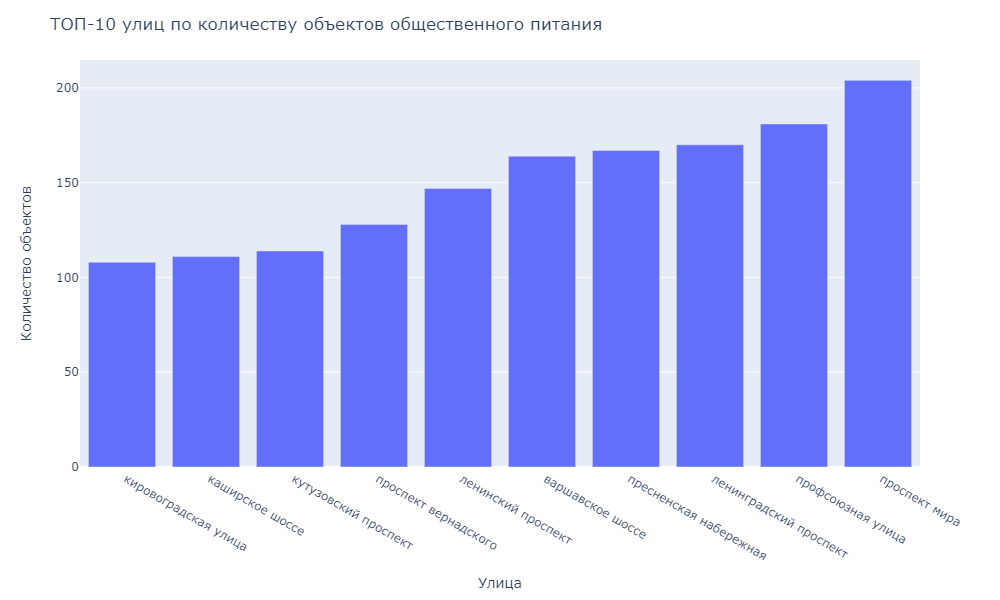

In [29]:
fig_8 = px.bar (data.groupby ('street')['object_name'].count().sort_values().tail(10), y = 'object_name', width = 1000, height = 600)
fig_set (fig_8, 'ТОП-10 улиц по количеству объектов общественного питания', 'Улица', 'Количество объектов')

Практически все улицы, представленные на графике выше, являются крупными улицами, относящимися к радиусам Москвы. Все они находятся между МКАДом и ТТК (третье транспортное кольцо), т.е. на наиболее загруженных маршрутах при выезде из центра города.

Рассмотрим районы, по которым проложены данные улицы. Используем датасет с улицами и районами Москвы из открытого источника АО "МОСГАЗ".

In [30]:
spreadsheet_id = '1b_jZggUyizA7guOQ5PtDlbSmOLNLLEcYPjzhYKZ-LeQ'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format (spreadsheet_id)
r = requests.get (file_name)
data_2 = pd.read_csv (BytesIO (r.content))
data_2.head (10)

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
5,Малый Гнездниковский переулок,17,ЦАО,Пресненский район
6,Большая Грузинская улица,17,ЦАО,Пресненский район
7,Малая Грузинская улица,17,ЦАО,Пресненский район
8,Грузинская площадь,17,ЦАО,Пресненский район
9,улица Грузинский Вал,17,ЦАО,Пресненский район


Нас интересуют только две колонки - `streetname` и `area`. Для дальнейшей работы приведём запись колонки `streetname` к нижнему регистру и избавимся от лишних колонок.

In [31]:
data_2 ['streetname'] = data_2 ['streetname'].str.lower()
data_2 = data_2 [['streetname', 'area']]
data_2.rename (columns = {'streetname': 'street'}, inplace = True)

В колонке `street` имеются записи с пробелом в начале строки. Их также необходимо обработать перед слиянием двух датасетов.

In [32]:
def space_delete (name):
    if ' ' in name [0]:
        return name.lstrip (' ')
    return name

data ['street'] = data ['street'].apply (space_delete)
data_with_area = data.merge (data_2, how = 'left')
data_with_area.sample (5)

,index,id,object_name,chain,object_type,address,seat_number,street,area
6096,3098,21234,СТОЛОВАЯ,нет,кафе,"город москва, улица кржижановского, дом 16, ко...",48,улица кржижановского,Район Котловка
7089,3667,68001,Карамель,нет,кафе,"город москва, изумрудная улица, дом 3, строение 2",96,изумрудная улица,Лосиноостровский район
1503,684,146123,Джаганнат,да,кафе,"город москва, проспект мира, дом 31",25,проспект мира,Ярославский Район
14827,7595,70046,Теремок,да,предприятие быстрого обслуживания,"город москва, ореховый бульвар, дом 22а",25,ореховый бульвар,Район Орехово-Борисово Южное
28007,14454,222838,Лепим и Варим,нет,кафе,"город москва, мытная улица, дом 74",0,мытная улица,Район Якиманка


Оба датасета объеденены. Количество строк увеличилось за счёт того, одна улица может входить одновременно в несколько районов. Посмотрим, к каким районам относятся наиболее загруженные по объектам общественного питания улицы.

In [33]:
top_10 = data.groupby ('street').agg ({'id': 'nunique'}).sort_values (by = 'id', ascending = False).head(10).index
data_with_area.query ('street in @top_10').groupby ('area').agg ({'street': 'nunique'}).sort_values (by = 'street',
                                                                                                     ascending = False)

,street
area,
Район Чертаново Центральное,2
Донской район,2
Ломоносовский район,2
Район Проспект Вернадского,2
Обручевский район,2
Район Теплый Стан,2
Район Нагатино-Садовники,2
Район Чертаново Южное,2
Район Тропарево-Никулино,2


Районы с двумя одновременно встречающимися улицами можно назвать - наиболее заполненные объектами общественного питания.

Найдём улицы с одним объектом общественного питания.

In [34]:
alone_streets = data.groupby ('street').agg ({'id': 'nunique'}).query ('id == 1')
display (alone_streets.sample (frac = 0.03))
print ('Количество улиц с одним объектом общественного питания:', len (alone_streets))

,id
street,
есенинский бульвар,1
федоскинская улица,1
ижорский проезд,1
средняя калитниковская улица,1
проезд досфлота,1
гвардейская улица,1
басовская улица,1
улица пивченкова,1
3-й угрешский проезд,1


Количество улиц с одним объектом общественного питания: 551


Опираясь на открытый ресурс Яндекс.Карты можно сделать вывод о том, что в основном улицы с одним объектом общественного питания находятся или на окраинах города, или в центре, но имеют небольшую протяжённость.

Используем данные датасета от АО "МОСГАЗ" о принадлежности Московский улиц к районам для определения наиболее часто встречающихся районов, включающих в себя улицы с одним объектом общественного питания.

In [35]:
alone_streets_names = alone_streets.index
data_with_area.query ('street in @alone_streets_names').groupby ('area').agg ({'street': 'nunique'}).sort_values (by = 'street',
                                                                                                     ascending = False).head (10)

,street
area,
Таганский район,27
Район Хамовники,26
Басманный район,25
Тверской район,20
Пресненский район,20
Район Арбат,18
Район Марьина роща,18
Мещанский район,16
Район Замоскворечье,14


Районы с двумя одновременно встречающимися улицами можно назвать - наиболее заполненные объектами общественного питания.

Рассмотрим распределение посадочных мест на наиболее заполненных объектами общественного питания улицах.

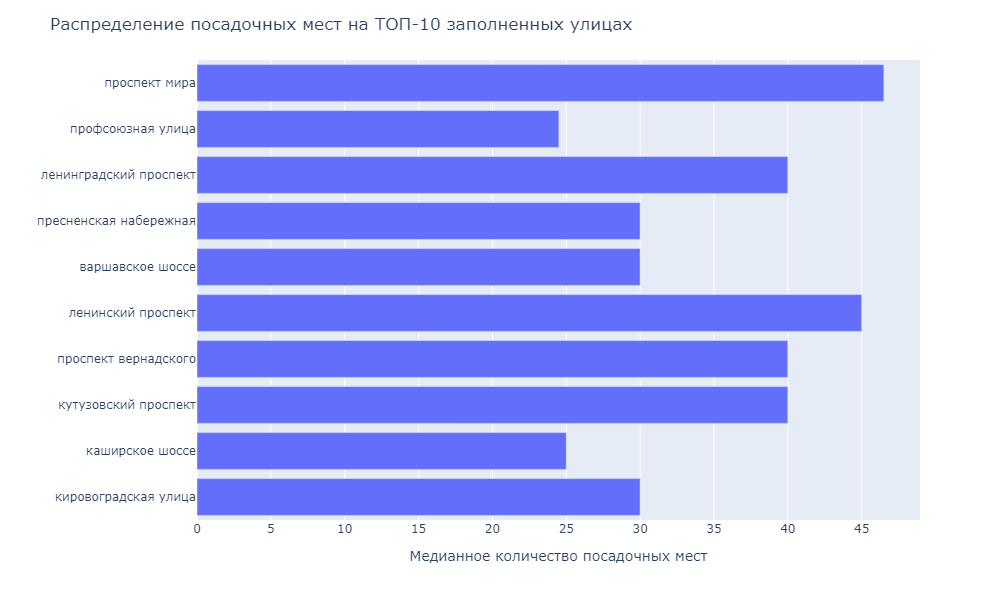

In [36]:
data_seats = data.groupby ('street')[['id', 'seat_number']].agg ({'id': 'count',
                                                                  'seat_number': 'median'}).reset_index().sort_values (by = 'id').tail(10)
fig_9 = px.bar (data_seats,
                x = 'seat_number',
                y = 'street',
                width = 1000,
                height = 600)
fig_set (fig_9, 'Распределение посадочных мест на ТОП-10 заполненных улицах', 'Медианное количество посадочных мест', '')

Медианное значение посадочных мест варьируется от 24 до 46 - это соответствует нормальным средним значениям.

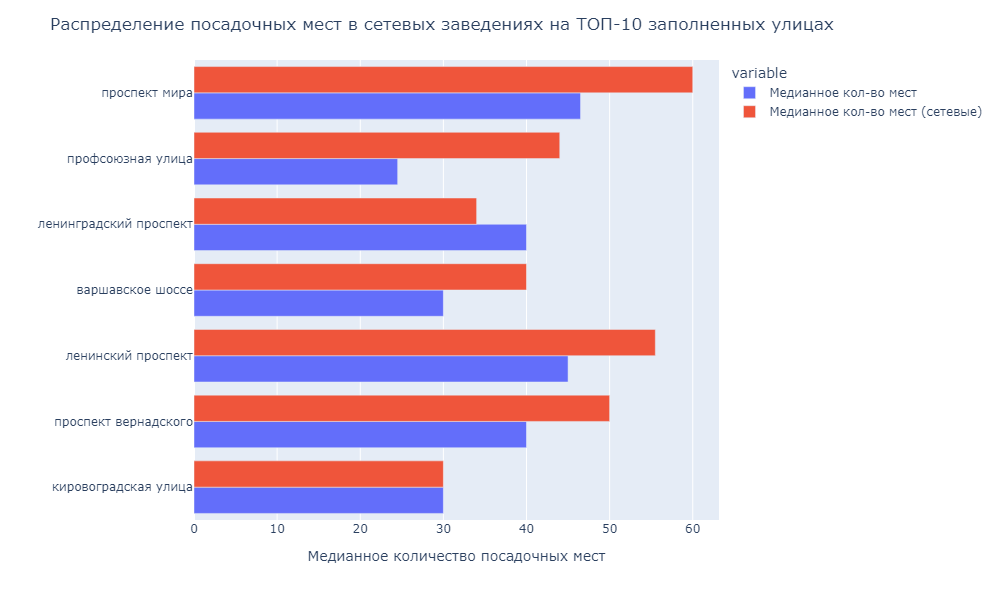

In [37]:
data_seats_chain = data.query ('chain == "да"').groupby ('street')[['id', 'seat_number']].agg ({'id': 'count',
                                                                                          'seat_number': 'median'}).reset_index().sort_values (by = 'id').tail(10)
data_seats = data_seats.merge (data_seats_chain, on = 'street').rename (columns = {'seat_number_x': 'Медианное кол-во мест',
                                                                                   'seat_number_y': 'Медианное кол-во мест (сетевые)'})
fig_10 = px.bar (data_seats,
                 x = ['Медианное кол-во мест', 'Медианное кол-во мест (сетевые)'],
                 y = 'street',
                 barmode = 'group',
                 width = 1000,
                 height = 600)
fig_set (fig_10, 'Распределение посадочных мест в сетевых заведениях на ТОП-10 заполненных улицах', 'Медианное количество посадочных мест', '')

При сравнении медианного количества посадочных мест в заведениях на ТОП-10 заполненных улицах с сетевыми заведениями на тех же улицах, можно сделать вывод, что практически во всех случаях количество мест в сетевых заведениях больше, чем в общем объёме заведений. Только на Ленинградском проспекте медианное кол-во мест в сетевых заведениях ниже общего показателя на 6 мест. В среднем, медиана по кол-ву мест в сетевых заведениях варируется от 30 до 60 мест, что значительно выше, чем общие показатели.

<a id='3'></a>
## Выводы и рекомендации

* Наиболее популярный вид объекта общественного питания - кафе
* Сетевых заведений примерно в 4 раза меньше, чем несетевых
* Наибольшее количество сетевых заведений - у предприятий быстрого обслуживания (более 40%)
* Есть довольно высокая вероятность встретить сетевой объект с небольшим количеством заведений и большим количеством мест
* Также немало сетевых объектов с небольшим количестом заведений и небольшим количеством мест. Возможно, на это влияет доля заведений с принципом работы "на вынос" - небольшие точки, где отсутствуют посадочные места как таковые
* Наибольшее количество мест - в столовых и ресторанах.

Самые популяные улицы с объектами общепита в Москве:
- Проспект Мира
- Профсоюзная улица
- Ленинградский проспект
- Пресненская набережная
- Варшавское шоссе
- Ленинский проспект
- Проспект Вернадского
- Кутузовский проспект
- Каширское шоссе
- Кировоградская улица

Все они находятся между МКАДом и ТТК, т.е. на наиболее загруженных маршрутах при выезде из центра города.

При открытии кафе, стоит рассмотреть данные улицы в первую очередь, т.к. он имеют высокую проходимость и конкурентную среду. Среди заведений, распологающихся на этих улицах, количество посадочных мест в среднем варьируется от 24 до 46. Ориентироваться стоит примерно на такой же диапазон. Стоит также рассмотреть возможность частичной организации работы "на вынос", т.к. небольшие заведения зачастую используют это в своей работе.